## Imports

In [2]:
import numpy as np
import pandas as pd
import itertools
import random
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from ALWGAN_new_v7_diversity.Models import NN_phi,NN_h,NN_h_RELU,NN_h_RELU2
from ALWGAN_new_v7_diversity.training import WAAL
from ALWGAN_new_v7_diversity.dataset_handler import myData
from ALWGAN_new_v7_diversity.Experiment_functions import *
from ALWGAN_new_v7_diversity.EarlyStop import EarlyStopper

from sklearn import datasets
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Preparing Data

In [3]:
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df["target"]=boston.target
y_boston=df.target
X_boston=df.drop("target",axis=1)
#scaler = RobustScaler()
#X_boston=pd.DataFrame(scaler.fit_transform(X_boston)).set_axis(X_boston.columns, axis=1)
y_boston=torch.Tensor(y_boston).view(len(y_boston),1).float()
X_boston=torch.Tensor(X_boston.values).float()


columns_names=["Frequency","Angle of attack","Chord length","Free-stream velocity","Suction side displacement thickness","sound pressure level"]
airfoil=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/airfoil_self_noise.dat',sep='\t',names=columns_names)
y_airfoil=airfoil["sound pressure level"]
X_airfoil=airfoil.drop("sound pressure level",axis=1)
y_airfoil=torch.Tensor(y_airfoil).view(len(y_airfoil),1).float()
X_airfoil=torch.Tensor(X_airfoil.values).float()


energy=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/energy efficiency.csv')
y_energy=energy["Y2"]
X_energy=energy.drop(["Y2","Y1"],axis=1)
y_energy=torch.Tensor(y_energy).view(len(y_energy),1).float()
X_energy=torch.Tensor(X_energy.values).float()


maintenance=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/conditions_based_maintenance/data.txt',sep="   ", header=None)
y_maintenance=maintenance[17]
X_maintenance=maintenance.drop([16,17],axis=1)
y_maintenance=torch.Tensor(y_maintenance).view(len(y_maintenance),1).float()
X_maintenance=torch.Tensor(X_maintenance.values).float()


"""forest=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/forestfires.csv')
y_forest=forest.area
X_forest=forest.drop("area",axis=1)
y_forest=torch.Tensor(y_forest).view(len(y_forest),1).float()
X_forest=torch.Tensor(X_forest.values).float()"""

C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

'forest=pd.read_csv(\'C:/Users/matth/jupyter codes/Recherche/datasets/forestfires.csv\')\ny_forest=forest.area\nX_forest=forest.drop("area",axis=1)\ny_forest=torch.Tensor(y_forest).view(len(y_forest),1).float()\nX_forest=torch.Tensor(X_forest.values).float()'

#### Preparing other functions

In [4]:
data_generated= 1000 #total data generated
proportion= 0.20 # proportion of dataset in testset

#Generate data
x= torch.tensor([[random.random()] for i in range(data_generated)])
y_carré=(0.5*x**2)

x_log=x+1
y_log=torch.log(x_log)

x_3dim= torch.tensor([[random.random(),random.random(),random.random()] for i in range(data_generated)])
y_3dim= torch.sum((1/(2*np.sqrt(3)))*x_3dim**2,1).view(data_generated,1)

x_hdim= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdim= torch.sum((1/(2*np.sqrt(10)))*x_hdim**2,1).view(data_generated,1).float()

x_b=torch.tensor([random.random() for i in range(data_generated)])

x_log_b=(x_b+1).view(x.size()[0],1)
y_log_b=(torch.log(x_b+1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(x.size()[0],1)

x_carré_b=x_b.view(x.size()[0],1)
y_carré_b=(x_b**2 + torch.tensor([np.random.normal(loc=0,scale=0.05) for i in range(data_generated)])).view(x.size()[0],1)

x_3dim_b= torch.tensor([[random.random(),random.random(),random.random()] for i in range(data_generated)])
y_3dim_b=(torch.sum((1/(2*np.sqrt(3)))*x_3dim_b**2,1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(data_generated,1) 

x_hdim_b= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdim_b= (torch.sum((1/(2*np.sqrt(10)))*x_hdim_b**2,1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(data_generated,1).float()

x_hdimsin_b= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdimsin_b= ((1/(4*np.sqrt(10)))*np.sin(4*torch.sum(x_hdimsin_b,1))+1+ torch.tensor([np.random.normal(loc=0,scale=0.008) for i in range(data_generated)])).view(data_generated,1).float()


scaler = MinMaxScaler()
X=X_airfoil
y=y_airfoil

X=torch.Tensor(scaler.fit_transform(X))


#splitting
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=proportion)



#generating testset
testset=myData(X_test,y_test)

#For Boston
#scaler_test = RobustScaler()
#y_train=torch.Tensor(scaler_test.fit_transform(y_train))

#taking limited number of datas to make the query process run faster
#X_train=X_train[:100]
#y_train=y_train[:100]

X_train.shape

torch.Size([1202, 5])

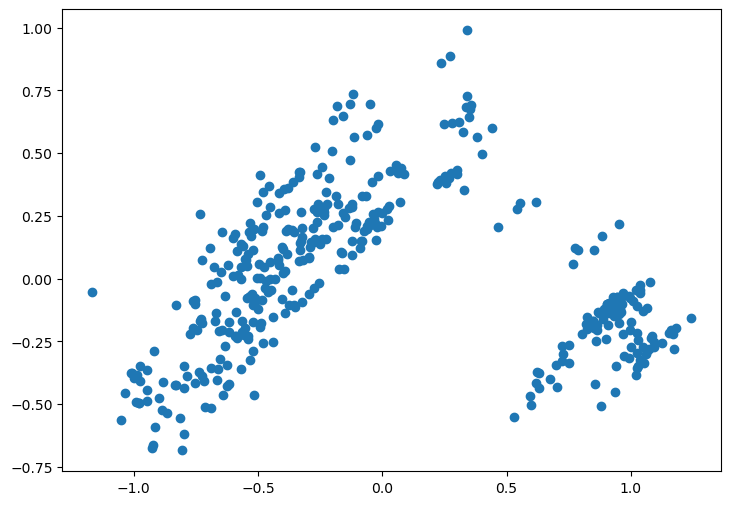

In [8]:
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=5)

transformed = pca.fit_transform(X=X_train)

# Isolate the data we'll need for plotting.
x_component = transformed[:, 0]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6))
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])

### Full training function

In [6]:
def full_training(strategy,num_round,X_test,y_test,show_losses,freq_display_figures,show_unlabelled,show_estim_chosen
                  ,reset_phi,reset_h,early_stop_method,config_NN_h,config_NN_phi,nb_initial_labelled_datas,patience=None,
                  min_delta=None,val_proportion=0,reduced=False,cnst_t3phi=1
                 ):
    start=time.time()
    t1_descend_list=[]
    val_t1_descend_list=[]
    t2_ascend_list=[]
    acc = []# MAE
    acc_percentage=[] #MAPE
    acc_rmse=[] #RMSE
    only_train=False
    strategy.h.train()
    for rd in range(1,num_round+1):
        #print(strategy.h.training)
        print('\n================Round {:d}==============='.format(rd))
        
        if rd==num_round:
            only_train=True

        if reset_phi==True:
            strategy.phi=NN_phi(dim_input,config_NN_phi,dim_output=1,norm="inf")
            strategy.opti_phi = optim.Adam(strategy.phi.parameters(), lr=lr_phi,maximize=True)


        if reset_h==True:
            strategy.h=NN_h_RELU(dim_input,config_NN_h,dim_output=1)
            strategy.opti_h = optim.Adam(strategy.h.parameters(), lr=lr_h)


        early_stopper=EarlyStopper(early_stop_method,patience=patience, min_delta=min_delta)
        t1_descend,val_t1_descend,t2_ascend,b_idxs=strategy.train(show_losses=show_losses,early_stopper=early_stopper
                                            ,val_proportion=val_proportion,reduced=reduced,cnst_t3phi=cnst_t3phi,
                                                                  only_train=only_train
                                                           )

        t1=list(map(lambda x: x.detach(),t1_descend))
        val_t1=list(map(lambda x: x.detach(),val_t1_descend))
        t2=list(map(lambda x: x.detach(),t2_ascend))
        t1_descend_list.append(t1)
        val_t1_descend_list.append(val_t1)
        t2_ascend_list.append(t2)
        if only_train==True:
            strategy.idx_lb[:]= True
        else:
            
            strategy.idx_lb[b_idxs] = True

        if(rd%freq_display_figures==0):
            display_loss_t1(t1,rd)
            #display_loss_val_t1(val_t1,rd)
            display_loss_t2(t2,rd)
            #display_phi(strategy.X_train,strategy.phi,rd)
            #display_chosen_labelled_datas(strategy.X_train,strategy.idx_lb,strategy.y_train,b_idxs,rd,strategy.h
             #                            ,show_unlabelled=show_unlabelled,show_estim_chosen=show_estim_chosen)
            
            #strategy.h.eval()
            #display_prediction(X_test,strategy.h,y_test,rd)
            display_chosen_labelled_datas_PCA(strategy.X_train,strategy.idx_lb,strategy.y_train,b_idxs,rd,strategy.h)

        strategy.h.eval()
        #print("eval ",strategy.h.training)
        acc_rmse.append(RMSE(X_test,y_test,strategy.h))   
        acc.append(MAE(X_test,y_test,strategy.h))
        acc_percentage.append(MAPE(X_test,y_test,strategy.h))
        strategy.h.train()
            
    print('\n================Final training===============')
    

    early_stopper=EarlyStopper(early_stop_method,patience=patience, min_delta=min_delta)
    t1_descend,val_t1_descend,t2_ascend,_=strategy.train(show_losses=show_losses
                                                       ,early_stopper=early_stopper,val_proportion=val_proportion
                                                       ,only_train=True,reduced=reduced,cnst_t3phi=cnst_t3phi
                                                       )
    t1=list(map(lambda x: x.detach(),t1_descend))
    val_t1=list(map(lambda x: x.detach(),val_t1_descend))
    t1_descend_list.append(t1)
    val_t1_descend_list.append(val_t1)
    
    #display_loss_t1(t1,rd)
    #strategy.h.eval()
    #display_prediction(X_test,strategy.h,y_test,"final")
    strategy.h.eval()
    acc.append(MAE(X_test,y_test,strategy.h))
    error_each_round=list(map(lambda x: x[0],acc))

    acc_percentage.append(MAPE(X_test,y_test,strategy.h))
    error_each_round_per=list(map(lambda x: x[0],acc_percentage))
    
    acc_rmse.append(RMSE(X_test,y_test,strategy.h)) 
    error_each_round_rmse=acc_rmse
    
    end=time.time()
    
    return start,end,error_each_round,error_each_round_per, error_each_round_rmse,t1_descend_list,val_t1_descend_list,t2_ascend_list

## Training one config

In [10]:
total_epoch_h=100 # number of epochs to train h each round (1)
total_epoch_phi=100 # number of epochs to train phi each round 
num_elem_queried= int(0.02*X_train.shape[0]) # number of elem queried each round  (2)#int(0.02*X_train.shape[0])
nb_initial_labelled_datas = int(0.02*X_train.shape[0]) #nb of labelled datas at round 0 (3)
lr_h=0.001  # learning rate h  (4)
lr_phi=0.01  # learning rate phi  
batch_size_train=len(X_train) # size of the batch in the training process (5) #len(X_train)
dim_input=13

config_NN_h=[2,16,32]
config_NN_phi=[2,16,32]

reset_phi=False
reset_h=False

reduced=True
cnst_t3phi=3
 
early_stop_method=None # "training" or "validation" (or anything else to disable it)
val_proportion=0.2
patience=5
min_delta=0

freq_display_figures=1
show_losses=False
show_unlabelled=True
show_estim_chosen=False

# number of rounds to use all the trainset: int(((1-proportion)*data_generated-nb_initial_labelled_datas)/num_elem_queried)
num_round=int(np.ceil((len(y_train)-nb_initial_labelled_datas)/num_elem_queried))  # number of rounds


# Generate the initial labeled pool
n_pool = len(y_train)
n_test = len(y_test)
idxs_lb = np.zeros(n_pool, dtype=bool)
idxs_tmp = np.arange(n_pool)
np.random.shuffle(idxs_tmp)
idxs_lb[idxs_tmp[:nb_initial_labelled_datas]] = True


#display_chosen_labelled_datas(X_train,idxs_lb,y_train,b_idxs=None,rd=None,init=True,show_unlabelled=show_unlabelled)


h=NN_h_RELU(dim_input,config_NN_h,dim_output=1)
opti_h = optim.Adam(h.parameters(), lr=lr_h,weight_decay=0.001)
phi=NN_phi(dim_input,config_NN_phi,dim_output=1,norm="inf")
opti_phi = optim.Adam(phi.parameters(), lr=lr_phi,maximize=True)


strategy = WAAL(X_train,y_train,idxs_lb,total_epoch_h,total_epoch_phi,batch_size_train,num_elem_queried,phi
                ,h,opti_phi,opti_h)
    
start,end,error_each_round,error_each_round_per,error_each_round_rmse,t1_descend_list,val_t1_descend_list,t2_ascend_list=full_training(
    strategy,num_round,X_test,y_test,show_losses,freq_display_figures,show_unlabelled,show_estim_chosen
    ,reset_phi,reset_h,early_stop_method,config_NN_h,config_NN_phi,nb_initial_labelled_datas,patience, min_delta,val_proportion,
    reduced,cnst_t3phi
    
)


print("\n\n")

time_execution(start,end) 


================Round 1===============
1.0 tensor(1.)
1.0 tensor(1.0000)


KeyboardInterrupt: 

C:\Users\matth\AppData\Local\Temp\ipykernel_232976\1439774841.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0.5, 1.0, 'T1 loss evolution each batch')

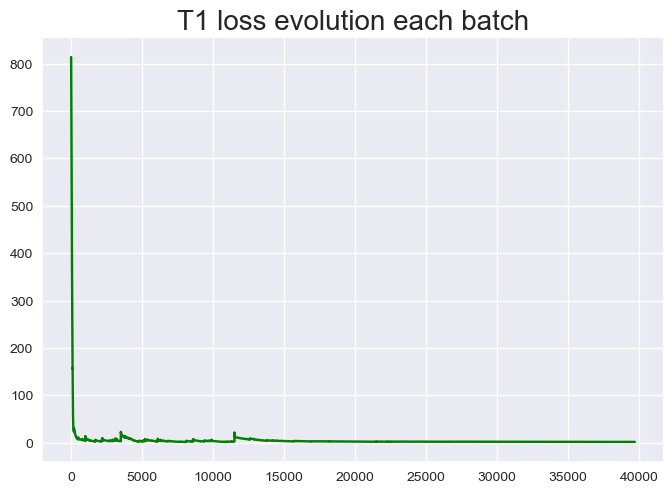

In [15]:
plt.style.use("seaborn")

plt.plot(list(itertools.chain(*t1_descend_list)),c="green")
plt.title("T1 loss evolution each batch",fontsize=20)
#plt.savefig('books_read.png')

Text(0.5, 1.0, 'val T1 loss evolution each batch')

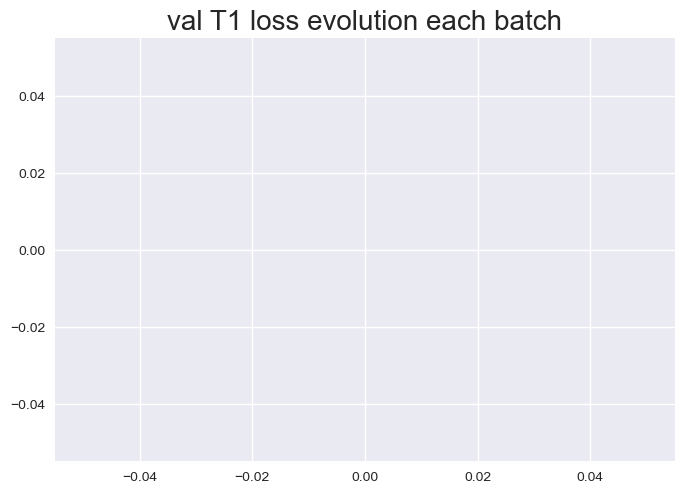

In [7]:
plt.plot(list(itertools.chain(*val_t1_descend_list)),c="orange")
plt.title("val T1 loss evolution each batch",fontsize=20)

Text(0.5, 1.0, 'T2 loss evolution each batch')

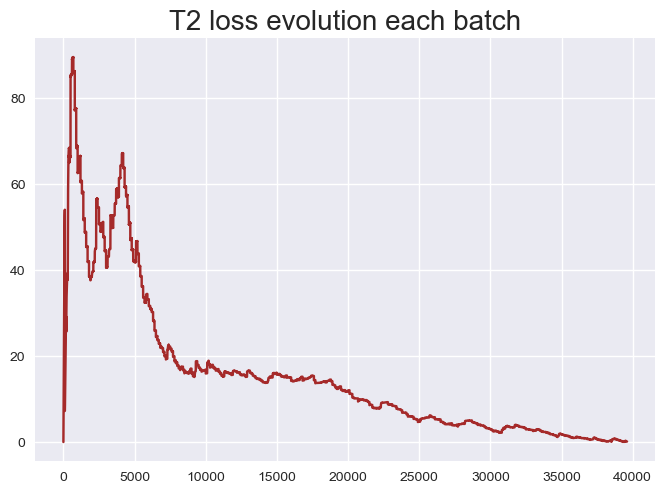

In [16]:
plt.plot(np.array(list(itertools.chain(*t2_ascend_list))),c="brown")
plt.title("T2 loss evolution each batch",fontsize=20)

Text(0.5, 1.0, 'RMSE of h each rounds')

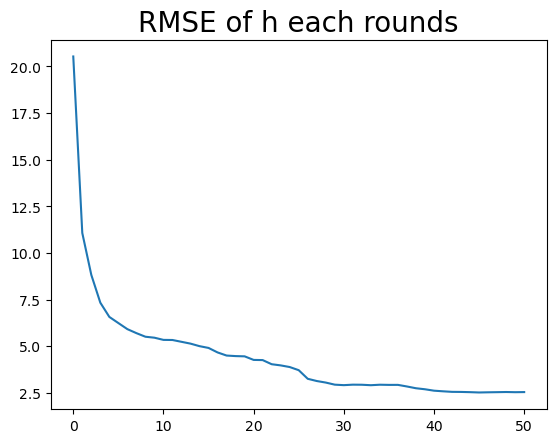

In [26]:
#round=round+1
plt.plot(error_each_round_rmse#,marker="o",c="b"
        )
plt.title("RMSE of h each rounds",fontsize=20)

In [28]:
error_each_round_rmse

[20.531984,
 11.073486,
 8.827919,
 7.337955,
 6.574514,
 6.2459707,
 5.91965,
 5.705811,
 5.513192,
 5.46132,
 5.344114,
 5.3380456,
 5.240858,
 5.143601,
 5.0077186,
 4.9128284,
 4.6719246,
 4.504606,
 4.475614,
 4.462323,
 4.2708187,
 4.2616286,
 4.040153,
 3.9771972,
 3.8888478,
 3.7203546,
 3.258662,
 3.1398027,
 3.0565834,
 2.9443686,
 2.9182785,
 2.9442255,
 2.9399443,
 2.9153883,
 2.9414172,
 2.932104,
 2.9332752,
 2.8470583,
 2.7526314,
 2.6977205,
 2.6219473,
 2.5885732,
 2.5591495,
 2.5547805,
 2.5427377,
 2.5257113,
 2.535121,
 2.542355,
 2.550556,
 2.5408928,
 2.5465236]

Text(0.5, 1.0, 'mean absolute error of h each rounds')

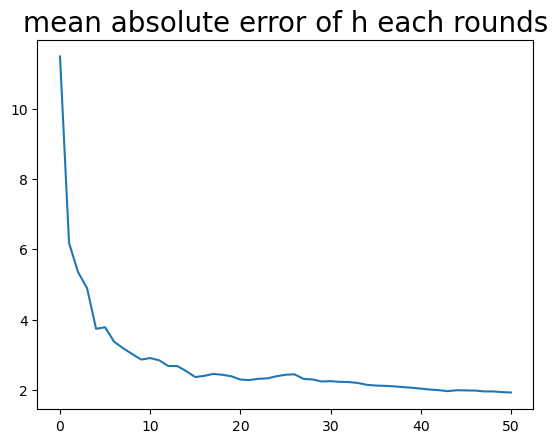

In [19]:
plt.plot(error_each_round
         #,marker="o",c="b"
        )
plt.title("mean absolute error of h each rounds",fontsize=20)

In [29]:
error_each_round

[18.208418,
 8.735082,
 6.944674,
 5.6142564,
 4.6589174,
 4.3189573,
 3.8585002,
 3.7929327,
 3.7042215,
 3.6351047,
 3.4801056,
 3.396841,
 3.3788044,
 3.4448347,
 3.4148805,
 3.3865626,
 3.2062814,
 3.1464212,
 3.1254706,
 3.1053474,
 3.096977,
 3.0694723,
 2.937055,
 2.8973155,
 2.8748977,
 2.7520428,
 2.430341,
 2.3352075,
 2.2657804,
 2.164787,
 2.1517484,
 2.1784177,
 2.1806571,
 2.1907322,
 2.2072213,
 2.1987593,
 2.1989968,
 2.1421332,
 2.0916197,
 2.0412989,
 1.9840332,
 1.964329,
 1.942701,
 1.9492961,
 1.9311975,
 1.9143828,
 1.9259405,
 1.9346266,
 1.9310657,
 1.9195658,
 1.9218241]

Text(0.5, 1.0, 'mean absolute percentage error of h each rounds')

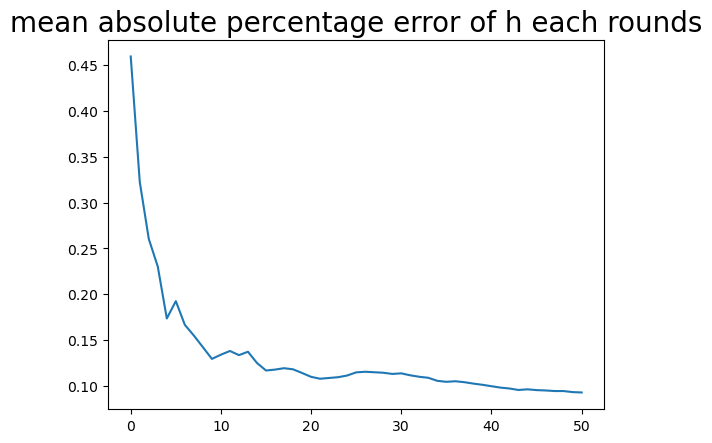

In [20]:
plt.plot(error_each_round_per#,marker="o",c="r"
        )
plt.title("mean absolute percentage error of h each rounds",fontsize=20)

In [30]:
error_each_round_per

[0.75508344,
 0.49939203,
 0.38198328,
 0.29354626,
 0.22750306,
 0.212822,
 0.18227738,
 0.18176357,
 0.17519458,
 0.17105864,
 0.16469876,
 0.16163528,
 0.16695535,
 0.17717735,
 0.17415886,
 0.17168932,
 0.16085565,
 0.15844117,
 0.15880613,
 0.15919805,
 0.16480426,
 0.16431762,
 0.15916343,
 0.15666117,
 0.1555667,
 0.14978741,
 0.13026866,
 0.1257947,
 0.12251492,
 0.11743631,
 0.11720129,
 0.1177019,
 0.117910594,
 0.118851036,
 0.119500734,
 0.11785625,
 0.11793177,
 0.11546132,
 0.11355727,
 0.11097674,
 0.10787195,
 0.106346264,
 0.10465908,
 0.10461229,
 0.103948146,
 0.10279157,
 0.103447594,
 0.10358709,
 0.103308775,
 0.102628976,
 0.10279138]

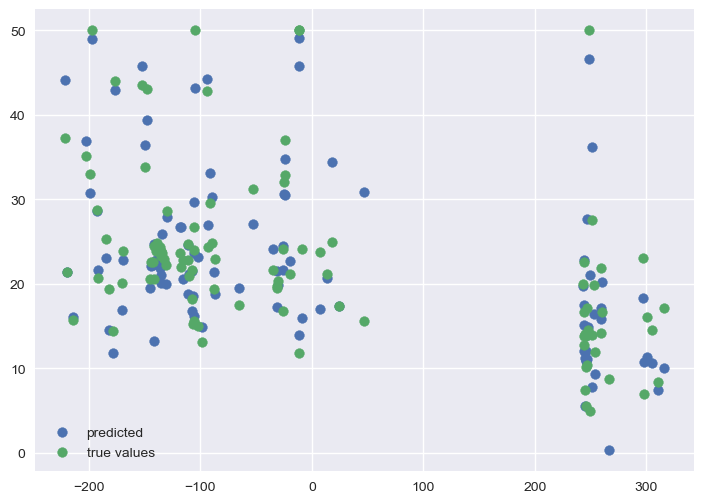

In [19]:
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=5)

transformed = pca.fit_transform(X=X_test)

# Isolate the data we'll need for plotting.
x_component = transformed[:, 0]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6))
plt.scatter(x=x_component, y=strategy.h(X_test).detach().numpy(),label="predicted")
plt.scatter(x=x_component, y=y_test,label="true values")
plt.legend()

## Training different configurations and save MAE,MAPE and duration of execution in excel

In [22]:
def get_config_NN(depth_l,heights_l):
    liste_config=[]
    for depth in depth_l:
        liste_config+=[[depth]+list(config) for config in itertools.product(heights_l, repeat=depth)]
    return liste_config       

In [35]:
configs_NN=[[16,32]]

[[3, 64, 128, 128],
 [3, 128, 24, 64],
 [3, 128, 128, 24],
 [2, 24, 64],
 [2, 128, 128],
 [3, 64, 24, 128],
 [3, 64, 128, 24],
 [2, 24, 24],
 [3, 128, 128, 64],
 [3, 24, 24, 64],
 [3, 128, 64, 24],
 [2, 128, 64]]

In [7]:
total_epoch_h=100 # number of epochs to train h each round (1)
total_epoch_phi=100 # number of epochs to train phi each round 
num_elem_queried=int(0.02*X_train.shape[0]) # number of elem queried each round  (2)
nb_initial_labelled_datas =int(0.02*X_train.shape[0]) #nb of labelled datas at round 0 (3)
lr_h=0.001  # learning rate h  (4)
lr_phi=0.01  # learning rate phi  
batch_size_train=len(X_train)  # size of the batch in the training process (5) #len(X_train)
dim_input=5
depth_l=[2,3]
heights_l=[24,64,128]

reset_phi=False
reset_h=False

reduced=True
cnst_t3phi_l=[3]

early_stop_method=0 # "training" or "v" (or anything else to disable it)
val_proportion=0.2
patience=3
min_delta=0

freq_display_figures=np.inf
show_losses=False
show_unlabelled=True
show_estim_chosen=False

#configs_NN=get_config_NN(depth_l,heights_l)
configs_NN=[[2,16,32]]

path_excel="C:/Users/matth/Desktop/cours et TD en tout genre_A4/parcours recherche/results benchmark/"
name_file="tuning_WAR_airfoil__diversity__h_RELU_minmax_fullbatch_noreset_2_pourcent_query_and_init_100epochs_both_lrphi=0.01_lrh=0.001_noearly_meanof3_reduce.xlsx"
liste_configs = [configs_NN,cnst_t3phi_l]
combinations = [elem for elem in itertools.product(*liste_configs)]
print("total number of configurations: ", len(combinations))
#duration_configs=[]

liste_moyennes=[]

for i in range(1):
    
    seed=random.randint(1,10000)
    results_i=[]
    
    for config_NN,cnst_t3phi in combinations:

        
        # Generate the initial labeled pool
        
        n_pool = len(y_train)
        n_test = len(y_test)
        idxs_lb = np.zeros(n_pool, dtype=bool)
        idxs_tmp = np.arange(n_pool)
        np.random.seed(seed)#same seed for every config
        np.random.shuffle(idxs_tmp)
        idxs_lb[idxs_tmp[:nb_initial_labelled_datas]] = True
        np.random.seed()# reset seed for the rest of the iteration
        
        print(f"\n iteration: {i} , config_NN: {config_NN}, cnst_t3phi: {cnst_t3phi}\n")
    
        # number of rounds to use all the trainset: int(((len(y_train)-nb_initial_labelled_datas)/num_elem_queried)
        num_round=int(np.ceil((len(y_train)-nb_initial_labelled_datas)/num_elem_queried))  # number of rounds
        
        
        h=NN_h_RELU(dim_input,config_NN,dim_output=1)
        opti_h = optim.Adam(h.parameters(), lr=lr_h,weight_decay=0.001)
        phi=NN_phi(dim_input,config_NN,dim_output=1,norm="inf")
        opti_phi = optim.Adam(phi.parameters(), lr=lr_phi,maximize=True)
        strategy = WAAL(X_train,y_train,idxs_lb,total_epoch_h,total_epoch_phi,batch_size_train,num_elem_queried,phi
                        ,h,opti_phi,opti_h)

        start,end,error_each_round,error_each_round_per,error_each_round_rmse,t1_descend_list,val_t1_descend_list,t2_ascend_list=full_training(
            strategy,num_round,X_test,y_test,show_losses,freq_display_figures,show_unlabelled,show_estim_chosen
            ,reset_phi,reset_h,early_stop_method,config_NN,config_NN,nb_initial_labelled_datas,patience, min_delta,val_proportion,
            reduced,cnst_t3phi
        )
        
        results=[error_each_round,error_each_round_per,error_each_round_rmse]
        results_i.append(results)
        #duration_config.append(time_execution(start,end))
    liste_moyennes.append(results_i)

full_results_mean=[]
for i in range(len(liste_moyennes[0])):
    result_config=[]
    for k in range(3): 
        liste_same_metric=[]
        for l in range(len(liste_moyennes[0][0][0])):
            moyenne=[]
            for j in range(3):
                moyenne.append(liste_moyennes[j][i][k][l])
            print(moyenne)
            liste_same_metric.append(np.array(moyenne).mean())
            
        result_config.append(liste_same_metric)
    df_temp = pd.DataFrame({"MAE":result_config[0],"MAPE":result_config[1],"RMSE":result_config[2]})
    sheet_name=f"{' '.join(list(map(lambda x: str(x),combinations[i][0])))} {combinations[i][1]}"
    with pd.ExcelWriter(path_excel+name_file,
                mode='a',engine="openpyxl") as writer:  
        df_temp.to_excel(writer
                 ,sheet_name=sheet_name)
    
        
    

        
"""df_duration_configs=pd.DataFrame({"time needed": duration_configs,"configuration":combinations})

with pd.ExcelWriter(path_excel+name_file,
                        mode='a',engine="openpyxl") as writer:  
        df_duration_configs.to_excel(writer
                         ,sheet_name="df_duration_configs")"""
        
       

total number of configurations:  1

 iteration: 0 , config_NN: [2, 16, 32], cnst_t3phi: 3


================Round 1===============
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0000001 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.)
1.0 tensor(1.)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0000001 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.)
1.0 tensor(1.)

================Round 2===============
1.0 tensor(1.)
1.0 tensor(1.)
1.0000001 tensor(1.)
0.99999994 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 ten

1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

================Round 17===============
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

================Round 18===============
1.0 tensor(1.0000

1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

================Round 32===============
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
0.99999994 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

================Round 33===============
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)


1.0000001 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

================Round 47===============
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0000001 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
0.99999994 tensor(1.0000)
0.99999994 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0000001 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(0.9999)

================Round 48===============
1.0 tensor(0.9999)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
0.9999999 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)
1.0 tensor(1.0000)

IndexError: list index out of range

In [8]:
full_results_mean=[]
for i in range(len(liste_moyennes[0])):
    result_config=[]
    for k in range(3): 
        liste_same_metric=[]
        for l in range(len(liste_moyennes[0][0][0])):
            moyenne=[]
            for j in range(1):
                moyenne.append(liste_moyennes[j][i][k][l])
            print(moyenne)
            liste_same_metric.append(np.array(moyenne).mean())
            
        result_config.append(liste_same_metric)
    df_temp = pd.DataFrame({"MAE":result_config[0],"MAPE":result_config[1],"RMSE":result_config[2]})
    sheet_name=f"{' '.join(list(map(lambda x: str(x),combinations[i][0])))} {combinations[i][1]}"
    with pd.ExcelWriter(path_excel+name_file,
                mode='a',engine="openpyxl") as writer:  
        df_temp.to_excel(writer
                 ,sheet_name=sheet_name)

[122.53706]
[103.659]
[51.785294]
[24.241045]
[22.843489]
[21.3567]
[19.600508]
[17.671072]
[15.400009]
[13.116243]
[10.867002]
[8.8272705]
[7.132874]
[5.7735696]
[4.8120265]
[4.2949743]
[3.9620285]
[3.7921097]
[3.744059]
[3.6881611]
[3.676512]
[3.622362]
[3.4569886]
[3.3383012]
[3.2845166]
[3.2565644]
[3.2583869]
[3.235609]
[3.1530578]
[3.1403573]
[3.1100144]
[3.0843701]
[3.0507739]
[2.9714746]
[2.8966506]
[2.8502169]
[2.810318]
[2.76781]
[2.760917]
[2.7574794]
[2.7050033]
[2.6762934]
[2.5846848]
[2.574637]
[2.569875]
[2.5584838]
[2.547054]
[2.5420907]
[2.520797]
[2.5047243]
[2.4789734]
[0.9825257]
[0.83002067]
[0.41097343]
[0.19369675]
[0.18324317]
[0.17143686]
[0.15740404]
[0.14216189]
[0.124038406]
[0.10583746]
[0.08781669]
[0.071266785]
[0.05754951]
[0.04654325]
[0.038802896]
[0.034498505]
[0.031713247]
[0.030306386]
[0.029890824]
[0.029500293]
[0.029444337]
[0.029013298]
[0.027683511]
[0.026720857]
[0.026284963]
[0.026035592]
[0.026050882]
[0.025878616]
[0.025227219]
[0.025134813